<a href="https://colab.research.google.com/github/dmswl0707/light_weighted_CNN_for_FER/blob/main/ckplus_train_test_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import shutil


In [166]:
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

True


In [167]:
from google.colab import drive

drive.mount('/content/drive/')
df_dir='/content/drive/My drive/Colab Notebooks/CK+48'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [168]:
transform_train=transforms.Compose([transforms.Resize((50,50)),
                                    transforms.Grayscale(),
                                    transforms.RandomRotation(degrees=30),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5),(0.5))
                                    ])

In [169]:
dataset = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/CK+48/train', transform=transform_train)


categories = list(dataset.class_to_idx.keys())
print(categories)
num_classes = len(categories)

print(len(dataset))
print(num_classes)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
981
7


In [170]:
image_h = 50
image_w = 50

test_size = 0.2 #0.2
val_size = 0.4 #0.2

num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)

test_split = int(np.floor(test_size * num_data))
val_split = int(np.floor(val_size * num_data))
test_idx, val_idx, train_idx = indices[:test_split], indices[test_split:val_split], indices[val_split:]

print(len(test_idx), len(val_idx), len(train_idx))

196 196 589


torch.Size([16, 1, 50, 50]) torch.Size([16])


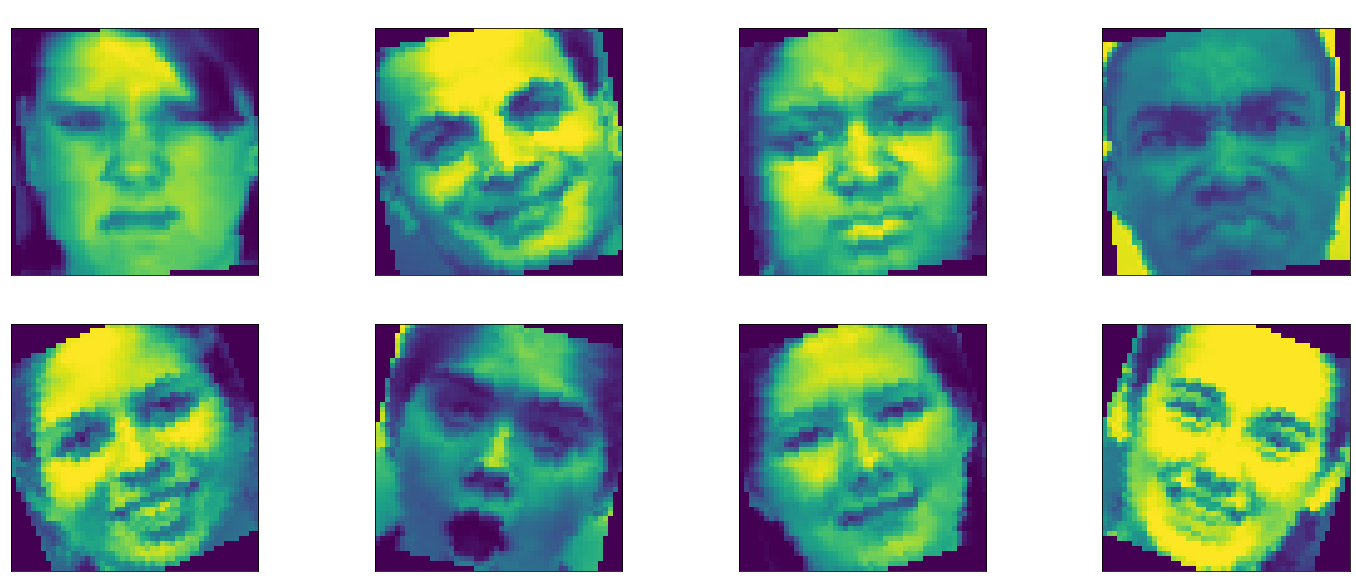

In [179]:

# define samplers for obtaining training and validation batche
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)


dataset_sizes = {
    'train' : len(train_idx),
    'test' : len(test_idx),
    'val' : len(val_idx)
}

loaders = {
    'train': torch.utils.data.DataLoader(dataset, batch_size=16, sampler=train_sampler),
    'test': torch.utils.data.DataLoader(dataset, batch_size=16, sampler=test_sampler),
    'val': torch.utils.data.DataLoader(dataset, batch_size=16, sampler=val_sampler),
}



def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = np.asarray(img)
    plt.imshow(np_img)


dataiter = iter(loaders['train'])
images, labels = dataiter.next()
print(images.shape,labels.shape)
images = images.numpy() 
fig = plt.figure(figsize=(25, 10))

for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(categories[int(labels[idx])],fontsize=20,color='white')

In [180]:
import torch.nn as nn
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F


class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels,
                                   bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class ResidualBlock(nn.Module):

    def __init__(self, in_channeld, out_channels):
        super(ResidualBlock, self).__init__()

        self.residual_conv = nn.Conv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=1, stride=2,
                                       bias=False)
        self.residual_bn = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)

        self.sepConv1 = SeparableConv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.elu = nn.ELU()

        self.sepConv2 = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        res = self.residual_conv(x)
        res = self.residual_bn(res)
        x = self.sepConv1(x)
        x = self.bn1(x)
        x = self.elu(x)
        x = self.sepConv2(x)
        x = self.bn2(x)
        x = self.maxp(x)
        return res + x


class Block(nn.Module):

    def __init__(self, in_channeld, out_channels):
        super(Block, self).__init__()

        self.sep1 = SeparableConv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=3, bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.elu1 = nn.ELU()
        self.sep2 = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.elu2 = nn.ELU()
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.sep1(x)
        x = self.bn1(x)
        x = self.elu1(x)

        x = self.sep2(x)
        x = self.bn2(x)
        x = self.elu2(x)
        x = self.maxp(x)

        return x


class SELayer(nn.Module):
    def __init__(self, in_channeld, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channeld, in_channeld // reduction, bias=False),
            nn.ReLU6(inplace=True),
            nn.Linear(in_channeld // reduction, in_channeld, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channeld, out_channels, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.Conv1 = nn.Conv2d(in_channeld, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(in_channeld)
        self.relu = nn.ReLU6(inplace=True)

        self.Conv2 = nn.Conv2d(in_channeld, out_channels, 1)
        self.bn2 = nn.BatchNorm2d(in_channeld)
        self.se = SELayer(in_channeld, reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.Conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.Conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Model(nn.Module):

    def __init__(self, num_classes):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, dilation=2, bias=False)
        self.bn1 = nn.BatchNorm2d(8, affine=True, momentum=0.99, eps=1e-3)
        self.relu1 = nn.ELU()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, dilation=2, bias=False)
        self.bn2 = nn.BatchNorm2d(8, momentum=0.99, eps=1e-3)
        self.relu2 = nn.ELU()


        self.module1 = ResidualBlock(in_channeld=8, out_channels=16)
        self.module2 = SEBasicBlock(16, 16, stride=1, downsample=None, groups=1,
                                    base_width=64, dilation=1, norm_layer=None, reduction=16)
        self.module3 = Block(in_channeld=16, out_channels=32)
        self.module4 = ResidualBlock(in_channeld=32, out_channels=64)
        self.module5 = SEBasicBlock(64, 64, stride=1, downsample=None, groups=1,
                                    base_width=64, dilation=1, norm_layer=None, reduction=16)
        self.module6 = Block(in_channeld=64, out_channels=128)


        self.last_conv = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=3, padding=1, stride=2)
        self.avgp = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.module4(x)
        x = self.module5(x)
        x = self.module6(x)
        x = self.last_conv(x)
        x = self.avgp(x)
        x = x.view((x.shape[0], -1))
        return x



In [150]:
def graph_loss(train_loss,test_loss):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(train_loss)
    ax.plot(test_loss)
    ax.legend(['Train Loss','Test Loss'])


In [173]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [181]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    train_loss, test_loss, val_loss = [], [], []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test','val']:
            if phase == 'train' or phase == 'val':
                model.train()  # Set model to training mode
            if phase == 'test':
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss.append(epoch_loss)
                #writer.add_scalar("Acc/train", epoch_acc, epoch)
                #writer.add_scalar("loss/train", epoch_loss, epoch)

            if phase == 'test' :
                test_loss.append(epoch_loss)
                #writer.add_scalar("Acc/test", epoch_acc, epoch)
                #writer.add_scalar("loss/test", epoch_loss, epoch)

            if phase == 'val' :
                val_loss.append(epoch_loss)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())



        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    #graph_loss(train_loss, test_loss)
    if phase == 'train':
        writer.add_scalar("Acc/train", epoch_acc, epoch)
        writer.add_scalar("loss/train", epoch_loss, epoch)

    if phase == 'test':
        writer.add_scalar("Acc/test", epoch_acc, epoch)
        writer.add_scalar("loss/test", epoch_loss, epoch)

    if phase == 'val':
        writer.add_scalar("Acc/val", epoch_acc, epoch)
        writer.add_scalar("loss/val", epoch_loss, epoch)


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [175]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            fig = plt.figure(figsize=(25, 16))

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = fig.add_subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_labels[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [182]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [183]:
model_ft = Model(num_classes=7)
model_ft = model_ft.to(device)
print(summary(model_ft,(1,50,50)))
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), momentum=0.9,lr=0.02, weight_decay=5e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              72
       BatchNorm2d-2            [-1, 8, 46, 46]              16
               ELU-3            [-1, 8, 46, 46]               0
            Conv2d-4            [-1, 8, 42, 42]             576
       BatchNorm2d-5            [-1, 8, 42, 42]              16
               ELU-6            [-1, 8, 42, 42]               0
            Conv2d-7           [-1, 16, 21, 21]             128
       BatchNorm2d-8           [-1, 16, 21, 21]              32
            Conv2d-9            [-1, 8, 42, 42]              72
           Conv2d-10           [-1, 16, 42, 42]             128
  SeparableConv2d-11           [-1, 16, 42, 42]               0
      BatchNorm2d-12           [-1, 16, 42, 42]              32
              ELU-13           [-1, 16, 42, 42]               0
           Conv2d-14           [-1, 16,

In [184]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=300)

Epoch 1/300
----------
train Loss: 2.3040 Acc: 0.2903
test Loss: 2.6565 Acc: 0.3980
val Loss: 2.0697 Acc: 0.3776

Epoch 2/300
----------
train Loss: 1.4334 Acc: 0.5229
test Loss: 1.1148 Acc: 0.5408
val Loss: 1.0936 Acc: 0.6020

Epoch 3/300
----------
train Loss: 1.0291 Acc: 0.6112
test Loss: 0.9193 Acc: 0.6939
val Loss: 0.9333 Acc: 0.6224

Epoch 4/300
----------
train Loss: 0.8406 Acc: 0.6927
test Loss: 0.8872 Acc: 0.6582
val Loss: 0.9123 Acc: 0.6378

Epoch 5/300
----------
train Loss: 0.6659 Acc: 0.7334
test Loss: 0.6756 Acc: 0.7500
val Loss: 0.6792 Acc: 0.7296

Epoch 6/300
----------
train Loss: 0.6794 Acc: 0.7504
test Loss: 0.6932 Acc: 0.7041
val Loss: 0.7989 Acc: 0.6990

Epoch 7/300
----------
train Loss: 0.5084 Acc: 0.8048
test Loss: 0.6148 Acc: 0.7857
val Loss: 0.6132 Acc: 0.7959

Epoch 8/300
----------
train Loss: 0.3675 Acc: 0.8761
test Loss: 0.4027 Acc: 0.8520
val Loss: 0.4268 Acc: 0.8520

Epoch 9/300
----------
train Loss: 0.3171 Acc: 0.9015
test Loss: 0.3872 Acc: 0.8724
val 

NameError: ignored

In [ ]:
# dilation = 2 추가